In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

np.random.seed(42)

In [2]:
anchor_metrics = {
    "latest_revenue_crore": 2358.2,   # Approx publicly reported
    "operating_margin_pct": 10.1,     # Approx operating margin
    "net_profit_margin_pct": 6.4,     # Approx net margin
    "region": "Gujarat"
}

anchor_metrics

{'latest_revenue_crore': 2358.2,
 'operating_margin_pct': 10.1,
 'net_profit_margin_pct': 6.4,
 'region': 'Gujarat'}

In [3]:
genders = ["Male", "Female", "Other"]
age_groups = ["0-17", "18-25", "26-35", "36-50", "51-65", "66+"]
income_levels = ["Low", "Lower-middle", "Middle", "Upper-middle", "High"]
urban_rural = ["Urban", "Rural"]

districts = [
    "Ahmedabad", "Surat", "Vadodara", 
    "Rajkot", "Bhavnagar", 
    "Gandhinagar", "Other"
]

In [4]:
n_rows = 50000

# Date range
dates = pd.date_range(start="2021-01-01", end="2024-12-31", freq="D")
rand_dates = np.random.choice(dates, size=n_rows)

# Demographic Assignments
rand_gender = np.random.choice(genders, size=n_rows, p=[0.51, 0.48, 0.01])
rand_age = np.random.choice(age_groups, size=n_rows,
                            p=[0.2, 0.15, 0.25, 0.2, 0.15, 0.05])
rand_income = np.random.choice(income_levels, size=n_rows,
                               p=[0.25, 0.3, 0.25, 0.15, 0.05])
rand_urban_rural = np.random.choice(urban_rural, size=n_rows, p=[0.6, 0.4])
rand_district = np.random.choice(districts, size=n_rows,
                                 p=[0.2, 0.15, 0.1, 0.1, 0.08, 0.05, 0.32])

In [5]:
base_sale = 100

sale_variation = np.random.normal(loc=0, scale=30, size=n_rows)

income_multiplier = {
    "Low": 0.8,
    "Lower-middle": 0.95,
    "Middle": 1.0,
    "Upper-middle": 1.2,
    "High": 1.5
}

mults = np.array([income_multiplier[i] for i in rand_income])
urban_mult = np.where(rand_urban_rural == "Urban", 1.1, 0.9)

sales_amt = np.maximum(base_sale * mults * urban_mult + sale_variation, 5)

# Margin logic
target_margin = anchor_metrics["operating_margin_pct"] / 100
margin_noise = np.random.normal(loc=0, scale=0.05, size=n_rows)

margin_pct = np.clip(target_margin + margin_noise, 0, 0.25)
cost_amt = sales_amt * (1 - margin_pct)
profit_amt = sales_amt - cost_amt

In [6]:
df_sales = pd.DataFrame({
    "date": rand_dates,
    "district": rand_district,
    "gender": rand_gender,
    "age_group": rand_age,
    "income_level": rand_income,
    "urban_rural": rand_urban_rural,
    "sales_amt_inr": sales_amt.round(2),
    "cost_amt_inr": cost_amt.round(2),
    "profit_amt_inr": profit_amt.round(2),
    "margin_pct": (margin_pct * 100).round(2),
})

df_sales.head()

,date,district,gender,age_group,income_level,urban_rural,sales_amt_inr,cost_amt_inr,profit_amt_inr,margin_pct
0,2024-02-01,Other,Male,0-17,Upper-middle,Urban,98.07,82.38,15.69,16.00
1,2024-12-30,Ahmedabad,Male,51-65,Low,Urban,67.01,58.86,8.15,12.16
2,2023-05-11,Other,Female,26-35,Middle,Urban,171.97,157.94,14.03,8.16
3,2024-07-18,Other,Female,18-25,Low,Urban,104.90,96.85,8.06,7.68
4,2024-02-05,Rajkot,Female,26-35,Middle,Rural,60.72,56.15,4.57,7.53


In [7]:
print("Total Rows:", len(df_sales))
print("Average Margin %:", df_sales["margin_pct"].mean())

df_sales.describe()

Total Rows: 50000
Average Margin %: 10.1378964


,date,sales_amt_inr,cost_amt_inr,profit_amt_inr,margin_pct
count,50000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2023-01-03 22:13:33.312000256,101.023429,90.767992,10.255426,10.137896
min,2021-01-01 00:00:00,5.000000,3.940000,0.000000,0.000000
25%,2022-01-05 00:00:00,76.490000,68.370000,5.530000,6.720000
50%,2023-01-07 00:00:00,100.085000,89.610000,9.340000,10.070000
75%,2024-01-02 00:00:00,124.320000,111.750000,13.930000,13.462500
max,2024-12-31 00:00:00,255.230000,241.710000,47.110000,25.000000
std,NaN,35.936853,32.687196,6.435139,4.902568


In [8]:
df_sales["month"] = df_sales["date"].dt.to_period("M")

monthly_summary = df_sales.groupby("month").agg({
    "sales_amt_inr": "sum",
    "profit_amt_inr": "sum",
    "margin_pct": "mean"
}).reset_index()

monthly_summary.head()

,month,sales_amt_inr,profit_amt_inr,margin_pct
0,2021-01,108815.47,11146.84,10.212614
1,2021-02,90772.28,9546.29,10.407572
2,2021-03,105386.80,10675.35,10.071611
3,2021-04,106598.89,10723.15,10.071826
4,2021-05,109047.24,11036.97,10.074156


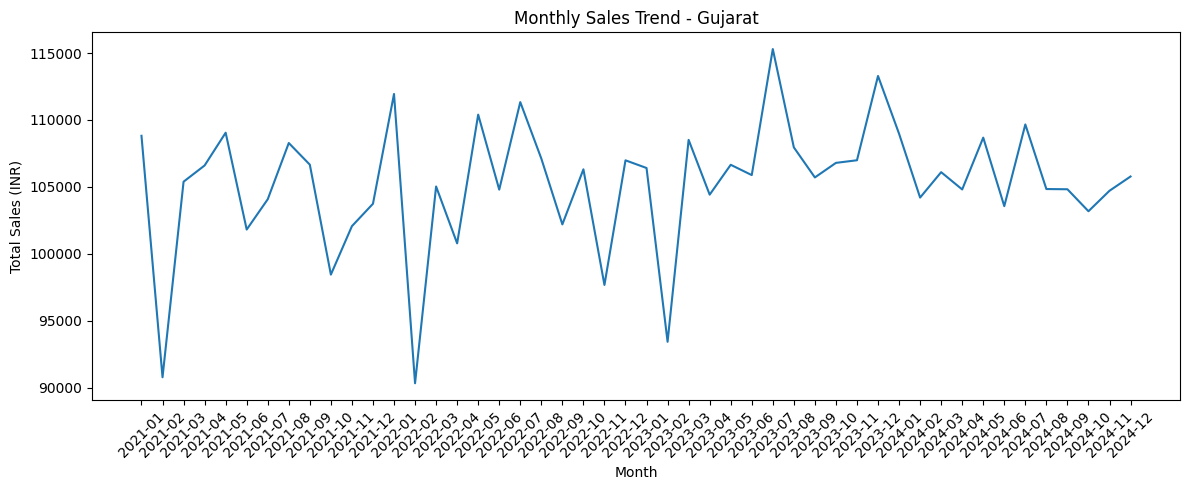

In [9]:
plt.figure(figsize=(12,5))
plt.plot(monthly_summary["month"].astype(str),
         monthly_summary["sales_amt_inr"])
plt.xticks(rotation=45)
plt.title("Monthly Sales Trend - Gujarat")
plt.xlabel("Month")
plt.ylabel("Total Sales (INR)")
plt.tight_layout()
plt.show()

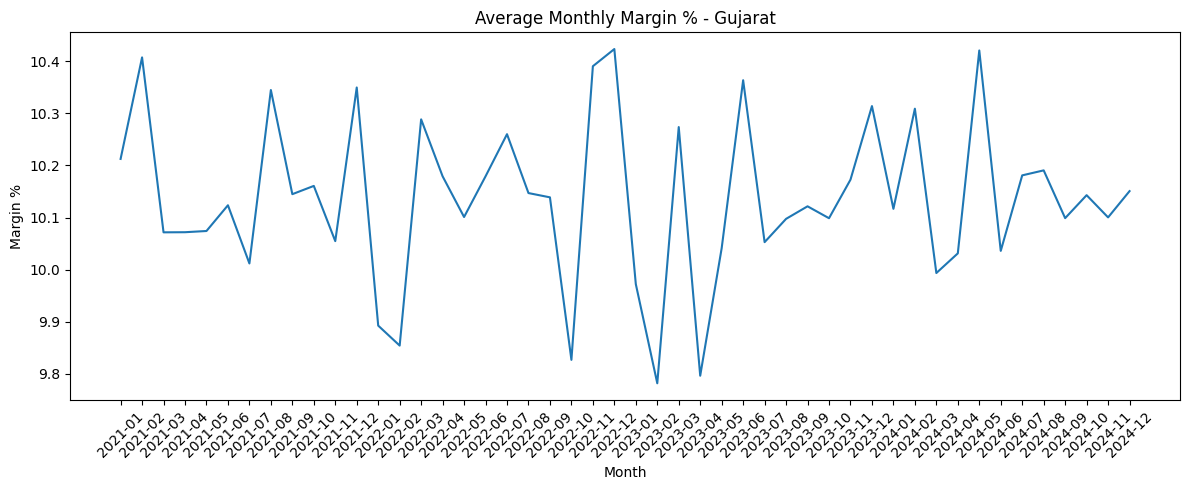

In [10]:
plt.figure(figsize=(12,5))
plt.plot(monthly_summary["month"].astype(str),
         monthly_summary["margin_pct"])
plt.xticks(rotation=45)
plt.title("Average Monthly Margin % - Gujarat")
plt.xlabel("Month")
plt.ylabel("Margin %")
plt.tight_layout()
plt.show()

In [11]:
output_path = Path("GTPPL_Gujarat_Sales_Profit_Demographics_50k.csv")
df_sales.to_csv(output_path, index=False)

print("Dataset saved successfully at:", output_path)

Dataset saved successfully at: GTPPL_Gujarat_Sales_Profit_Demographics_50k.csv
